In [1]:
import vice

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import surp

import surp.gce_math as gcem
import arya

In [4]:
import sys
sys.path.append(".")

In [5]:
from mc_plot_utils import MCMCResult

In [6]:
import mc_plot_utils

In [7]:
import cc_plot_utils

In [8]:
from scipy import interpolate

In [13]:
def print_ys_spline(model):
    median = model.samples.median()

    keys = [str(key) for key in median.keys() if key.startswith("spline") ]


    ys = []
    for i in range(len(keys)):
        param = median[f"spline_{i}"]
        ys.append(f"{param * 1e-3:0.2e}")

    s = str(ys)
    print(s.replace("'", ""))


# Utilities

In [15]:
def load_model(filename, y_model, y_agb, test=False, burn=0, **kwargs):
  
    if test:
        result = MCMCResult.from_test_file(filename, burn=burn)
    else:
        result = MCMCResult.from_file("../models/mcmc_models_2d/" + filename + "/", burn=burn, **kwargs)

    result.y_model = y_model
    result.y_agb = y_agb
    return result

## CC utilites

In [71]:
y_cc_z0 = lambda z: 1e-3
y_cc_z1 = np.vectorize(lambda z: 1*y_cc_z0(z) + surp.yield_models.Lin_CC(slope=0.001 / surp.Z_SUN, y0=0)(z))
y_cc_z2 = np.vectorize( surp.yield_models.Polynomial_CC([1e-3, 2e-3, 1e-3]))
y_cc_z3 = np.vectorize( surp.yield_models.Polynomial_CC([1e-3, 3e-3, 3e-3, 1e-3]))
y_cc_z4 = np.vectorize( surp.yield_models.Polynomial_CC([1e-3, 4e-3, 6e-3, 4e-3, 1e-3]))
y_cc_z5 = np.vectorize( surp.yield_models.Polynomial_CC([1e-3, 5e-3, 10e-3, 10e-3, 5e-3, 1e-3]))


In [17]:
def y_cc_lin(sample):
    y = lambda Z: sample.y0_cc * y_cc_z0(Z) + sample.zeta_cc * y_cc_z1(Z)
    return y

In [18]:
y_mg = vice.yields.ccsne.settings["mg"]

In [19]:
gcem.MH_to_Z([-1, -0.6, -0.2, 1])

array([0.00176   , 0.00442092, 0.01110485, 0.176     ])

In [20]:
gcem.Z_to_MH([0.000176, 0.00176, 0.00442092, 0.00700669, 0.01110485, 0.0176, 0.02789412, 0.0442092])

array([-2.        , -1.        , -0.60000001, -0.39999976, -0.19999997,
        0.        ,  0.2       ,  0.39999999])

In [73]:
def y_cc_spline(sample, Zs = [0.000176, 0.00176, 0.00442092, 0.00700669, 0.01110485, 0.0176, 0.02789412, 0.0442092]):
    y = np.vectorize(1e-3 * surp.yield_models.Spline_CC(Zs, [sample[f"spline_{i}"] for i in range(len(Zs))]))
    return y


def y_cc_spline_4(sample):
    return y_cc_spline(sample, [0.00176, 0.00442092, 0.01110485, 0.176])

### Load up AGBS

In [22]:
agb_interpolator = surp.agb_interpolator.interpolator

In [23]:
surp.set_yields(surp.yield_params.YieldParams.from_file("../models/fiducial/best/yield_params.toml"))

In [24]:

Y_agbs = {
    "fruity": agb_interpolator("c"),
    "fruity_m0.7": agb_interpolator("c", mass_factor=0.7),
    "aton": agb_interpolator("c", study="ventura13"),
    "monash": agb_interpolator("c", study="karakas16"),
    "nugrid": agb_interpolator("c", study="pignatari16"),
}

In [33]:
M_H_plot = np.linspace(-4.0, 0.5, 1000)
Z_plot = gcem.MH_to_Z(M_H_plot)

surp.set_yields(verbose=False)
ys_fiducial = surp.yields.calc_y(Z_plot)

y_agbs = {}
for key, Y_agb in Y_agbs.items():
    print(Y_agb)
    vice.yields.agb.settings["c"] = Y_agb
    ys_a = surp.yields.calc_y(Z_plot, kind="agb")
    
    y_agbs[key] = interpolate.interp1d(Z_plot, ys_a, fill_value="extrapolate")


1.00 × cristallo11
1.00 × cristallo11
1.00 × ventura13
1.00 × karakas16
1.00 × pignatari16


## Plot Utilities

In [35]:
def plot_yield(y, **kwargs):
    x = np.linspace(-2, 1, 1000)
    z = gcem.MH_to_Z(x)
    plt.plot(x, np.vectorize(y)(z), **kwargs)

# Load results

In [36]:
results = {}

In [39]:
results["fiducial"] = load_model("fiducial", y_cc_lin, y_agbs["fruity"])

In [40]:
results["fiducial_spline"] = load_model("fiducial_spline", y_cc_spline, y_agbs["fruity"])

In [41]:
results["fiducial_sigma"] = load_model("fiducial_sigma", y_cc_lin, y_agbs["fruity"])

In [42]:
results["fruity_mf0.7_spline"] = load_model("fruity_mf0.7_spline", y_cc_spline, y_agbs["fruity_m0.7"])

In [43]:
results["fiducial_constrained"] = load_model("fiducial_constrained", y_cc_lin, y_agbs["fruity"])

In [44]:
results["aton"] = load_model("aton", y_cc_lin, y_agbs["aton"])

In [45]:
results["aton_constrained"] = load_model("aton_constrained", y_cc_lin, y_agbs["aton"])

In [46]:
results["monash"] = load_model("monash", y_cc_lin, y_agbs["monash"])

In [47]:
results["eta2"] = load_model("eta2", y_cc_lin, y_agbs["fruity"])

In [48]:
results["lateburst"] = load_model("lateburst", y_cc_lin, y_agbs["fruity"])

In [49]:
results["twoinfall"] = load_model("twoinfall", y_cc_lin, y_agbs["fruity"])

In [50]:
results["sneia_1.2"] = load_model("sneia_1.2", y_cc_lin, y_agbs["fruity"])

In [51]:
results["fiducial_1d"] = load_model("../mcmc_models_1d/fiducial", y_cc_lin, y_agbs["fruity"])

In [52]:
results["fiducial_spline_1d"] = load_model("../mcmc_models_1d/fiducial_spline", y_cc_spline, y_agbs["fruity"])

In [76]:
results["fiducial_4spline"] = load_model("4spline/fiducial", y_cc_spline_4, y_agbs["fruity"])

## Surveys

In [264]:
results["v21"] = load_model("fiducial_vincenzo", y_cc_lin, y_agbs["fruity"])

length of samples =  48000
{'datafile': 'vincenzo+2021', 'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0]}}


In [265]:
results["v21_constrained"] = load_model("fiducial_vincenzo_constrained",  y_cc_lin, y_agbs["fruity"])

adding  y0_cc
length of samples =  48000
{'datafile': 'vincenzo+2021', 'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [0.79, 0.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0]}}


In [266]:
results["gso"] = load_model("fiducial_gso", y_cc_lin, y_agbs["fruity"])

length of samples =  48000
{'datafile': '~/surp/carbon_paper/data_analysis/gso_dwarfs.csv', 'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0]}}


In [267]:
results["gso_constrained"] = load_model("fiducial_gso_constrained",  y_cc_lin, y_agbs["fruity"])

adding  y0_cc
length of samples =  48000
{'datafile': '~/surp/carbon_paper/data_analysis/gso_dwarfs.csv', 'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [0.79, 0.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0]}}


In [268]:
results["galah"] = load_model("fiducial_galah",  y_cc_lin, y_agbs["fruity"])

length of samples =  48000
{'datafile': '~/surp/carbon_paper/data_analysis/galah_dwarfs.csv', 'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0]}}


In [269]:
results["galah_constrained"] = load_model("fiducial_galah_constrained",  y_cc_lin, y_agbs["fruity"])

adding  y0_cc
length of samples =  48000
{'datafile': '~/surp/carbon_paper/data_analysis/galah_dwarfs.csv', 'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [0.79, 0.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0]}}


# Plots

In [61]:
def plot_y_tot_mean(result, M_H=M_H_plot,  **kwargs):
    samples = result.samples
    Z = gcem.MH_to_Z(M_H)
        

    sample = samples.median()
    y_cc = result.y_model(sample)(Z)
    y_agb = result.y_agb(Z) * sample.alpha
    yt = y_agb + y_cc
        
    plt.plot(M_H_plot, yt / y_mg, **kwargs)


In [62]:
def plot_y_cc_mean(result, M_H=M_H_plot, **kwargs):
    samples = result.samples
    Z = gcem.MH_to_Z(M_H)
        

    sample = samples.median()
    y_cc = result.y_model(sample)(Z)        
    plt.plot(M_H_plot, y_cc / y_mg, **kwargs)


In [63]:
def plot_y_tot(result, thin=1000, M_H=M_H_plot, color="black", alpha=None, label="", **kwargs):
    samples = result.samples

    if alpha is None:
        alpha = 1 / len(samples[::thin])**(1/3) / 10
        
    Z = gcem.MH_to_Z(M_H)

    for i, sample in samples[::thin].iterrows():
        y_cc = result.y_model(sample)(Z)
        y_agb = result.y_agb(Z) * sample.alpha
        yt = y_agb + y_cc
            
        plt.plot(M_H, yt / y_mg, color=color, alpha=alpha, rasterized=True, **kwargs)
    
    plt.plot([], [], color=color, alpha=0.5, label=label)
    



In [64]:
def plot_y_cc(result, thin=1000, M_H=M_H_plot, color="black", alpha=None, label="", **kwargs):
    samples = result.samples

    if alpha is None:
        alpha = 1 / len(samples[::thin])**(1/3) / 10
        
    Z = gcem.MH_to_Z(M_H)

    for i, sample in samples[::thin].iterrows():
        y_cc = result.y_model(sample)(Z)
            
        plt.plot(M_H, y_cc / y_mg, color=color, alpha=alpha, rasterized=True, **kwargs)
    

    plt.plot([], [], color=color, alpha=0.5, label=label)




In [65]:
def compare_y_tot_mean(labels):
    plt.xlabel("[M/H]")
    plt.ylabel(r"$y_{\rm C}^{\rm tot} / y_{\rm Mg}$")

    for (key, label) in labels.items():
        plot_y_tot_mean(results[key], label=label)

    plt.legend()

    

In [66]:
def compare_y_cc_mean(labels):
    plt.xlabel("[M/H]")
    plt.ylabel(r"$y_{\rm C}^{\rm CC} / y_{\rm Mg}$")

    for (key, label) in labels.items():
        plot_y_cc_mean(results[key], label=label)

    plt.legend()

    

In [67]:
def compare_y_tot(labels):
    plt.xlabel("[M/H]")
    plt.ylabel(r"$y_{\rm C}^{\rm tot} / y_{\rm Mg}$")

    for (i, (key, label)) in enumerate(labels.items()):
        plot_y_tot(results[key], label=label, color=arya.COLORS[i])

    plt.legend()

    

In [68]:
def compare_y_cc(labels):
    plt.xlabel("[M/H]")
    plt.ylabel(r"$y_{\rm C}^{\rm CC} / y_{\rm Mg}$")

    for (i, (key, label)) in enumerate(labels.items()):
        plot_y_cc(results[key], label=label, color=arya.COLORS[i])

    plt.legend()

    

# Comparisons

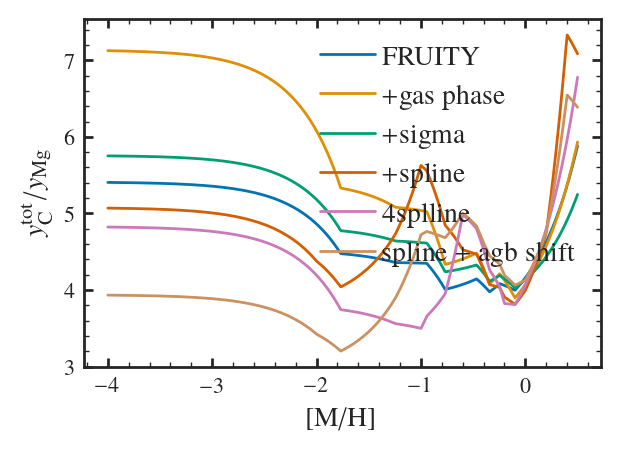

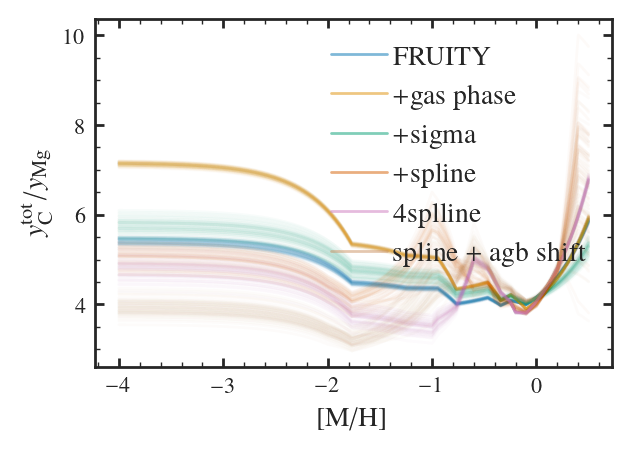

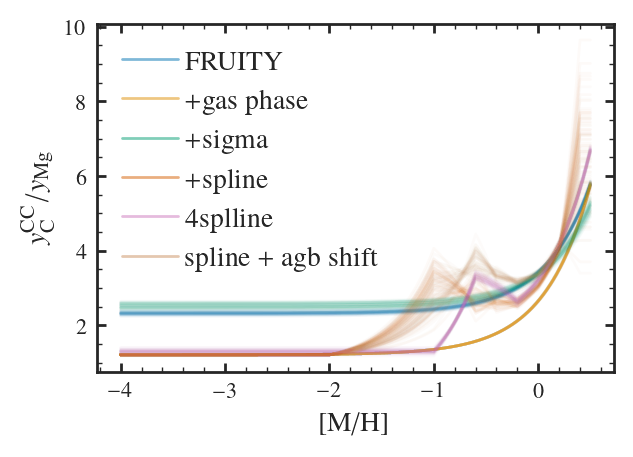

In [77]:
labels = {
    "fiducial": "FRUITY",
    "fiducial_constrained": "+gas phase",
    "fiducial_sigma": "+sigma",
    "fiducial_spline": "+spline",
    "fiducial_4spline": "4splline",
    "fruity_mf0.7_spline": "spline + agb shift",
}


compare_y_tot_mean(labels)
plt.show()
compare_y_tot(labels)

plt.show()
compare_y_cc(labels)


(-1.0, 0.6)

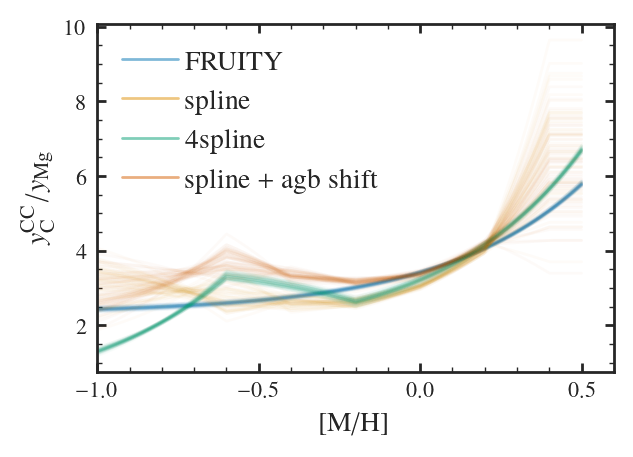

In [79]:
labels = {
    "fiducial": "FRUITY",
    "fiducial_spline": "spline",
    "fiducial_4spline": "4spline",
    "fruity_mf0.7_spline": "spline + agb shift",
}

compare_y_cc(labels)
plt.xlim(-1, 0.6)

In [224]:
results["fiducial"].params

{'alpha': {'name': 'perturbations/fruity',
  'prior': 'Normal',
  'prior_args': [1.0, 1.0]},
 'y0_cc': {'name': 'perturbations/constant',
  'prior': 'Normal',
  'prior_args': [2.0, 1.0]},
 'zeta_cc': {'name': 'perturbations/linear',
  'prior': 'Normal',
  'prior_args': [0.0, 2.0],
  'y0': 0.001}}

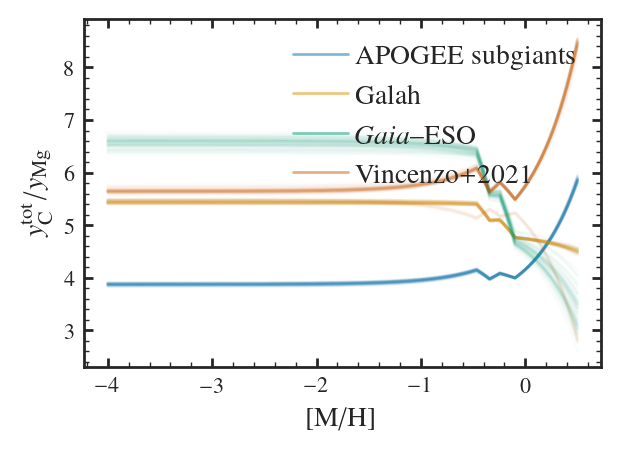

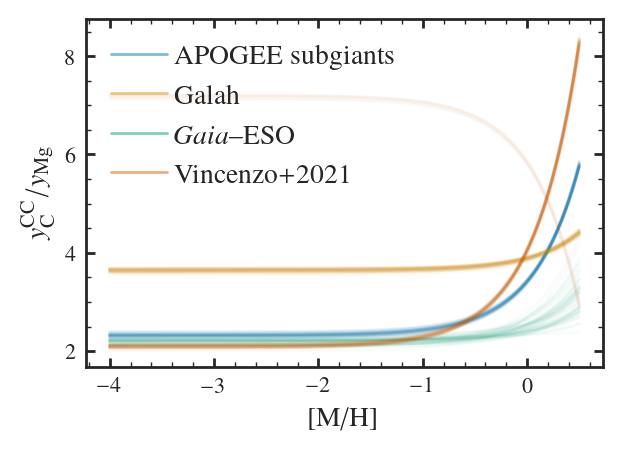

In [270]:
plot_labels = {
    "fiducial": r"APOGEE subgiants",
    "galah": r"Galah",
    "gso": r"{\it Gaia}--ESO",
    "v21": r"Vincenzo+2021",
    # "v21_constrained" : "+constrained"
}

compare_y_tot(plot_labels)
plt.show()
compare_y_cc(plot_labels)

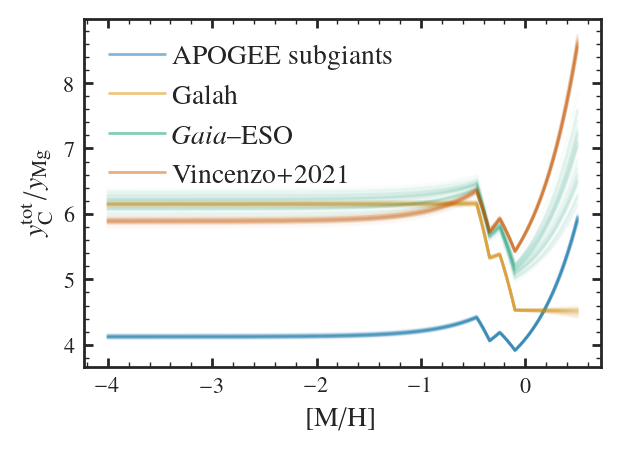

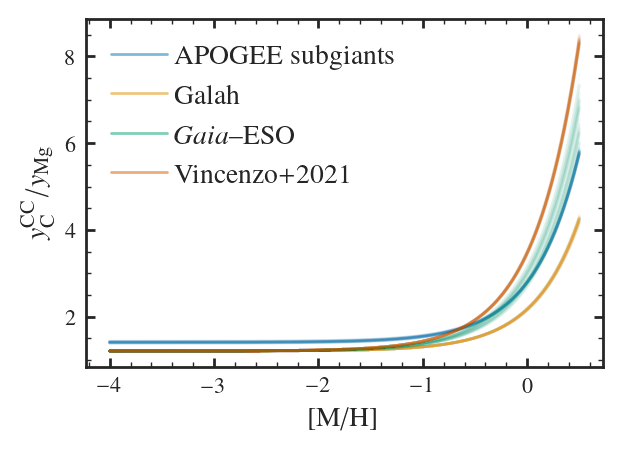

In [272]:
plot_labels = {
    "fiducial_constrained": r"APOGEE subgiants",
    "galah_constrained": r"Galah",
    "gso_constrained": r"{\it Gaia}--ESO",
    "v21_constrained": r"Vincenzo+2021",
    # "v21_constrained" : "+constrained"
}

compare_y_tot(plot_labels)
plt.show()
compare_y_cc(plot_labels)

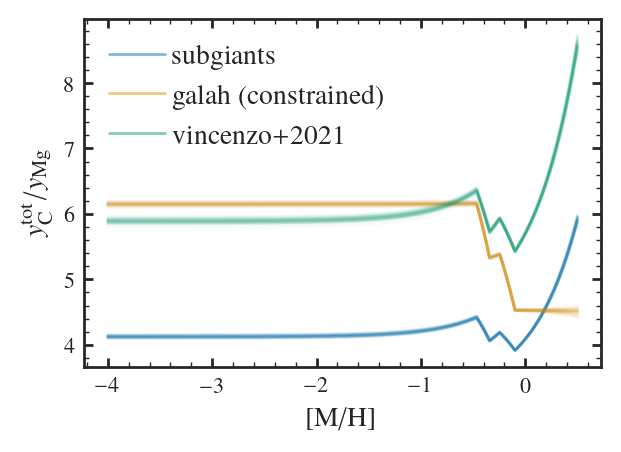

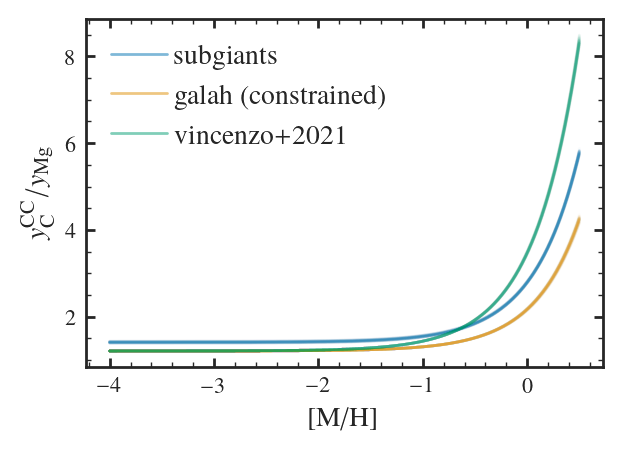

In [271]:
plot_labels = {
    "fiducial_constrained": r"subgiants",
    "galah_constrained": r"galah (constrained)",
    #"gso_constrained": r"gso",
    "v21_constrained" : "vincenzo+2021"
}

compare_y_tot(plot_labels)
plt.show()
compare_y_cc(plot_labels)

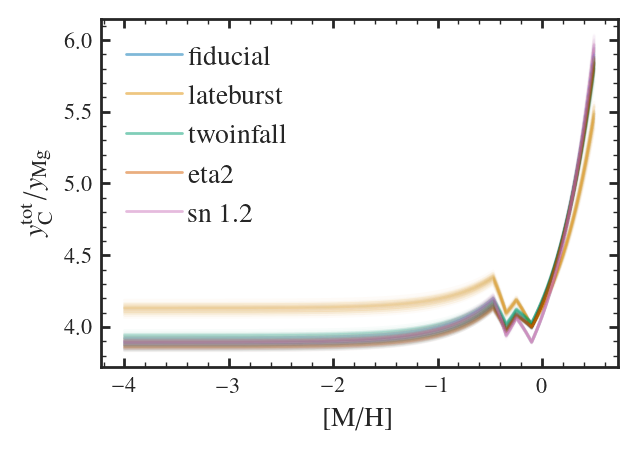

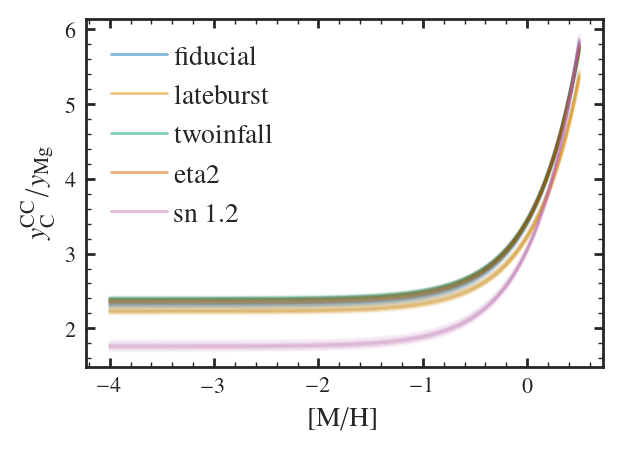

In [263]:
plot_labels = {
    "fiducial": r"fiducial",
    "lateburst": r"lateburst",
    #"gso_constrained": r"gso",
    "twoinfall" : "twoinfall",
    "eta2" : "eta2",
    "sneia_1.2": "sn 1.2"
    
}

compare_y_tot(plot_labels)
plt.show()
compare_y_cc(plot_labels)

# Validation

In [46]:
def plot_ana(y0, slope, **kwargs):
    x = np.linspace(-1, 0.5, 1000)
    Z = gcem.MH_to_Z(x)

    y_model = np.vectorize(surp.yield_models.Lin_CC(slope = slope / surp.Z_SUN, y0=y0))

    y = y_model(Z)

    plt.plot(x, y / y_mg, **kwargs)

In [121]:
plot_labels = {
    "fruity": r"FRUITY",
    "aton": r"ATON",
    "monash": r"Monash",
    "nugrid": r"NuGrid",
   # "analytic": r"analytic",    
    "fiducial_constrained": r"FRUITY + gas",

    "fruity_m0.7": r"FRUITY m0.7",

    # "eta2": r"$y\rightarrow 2y$",
    # "lateburst": r"lateburst",
    # "twoinfall": r"twoinfall",
}

warning, no agb for  fiducial_constrained


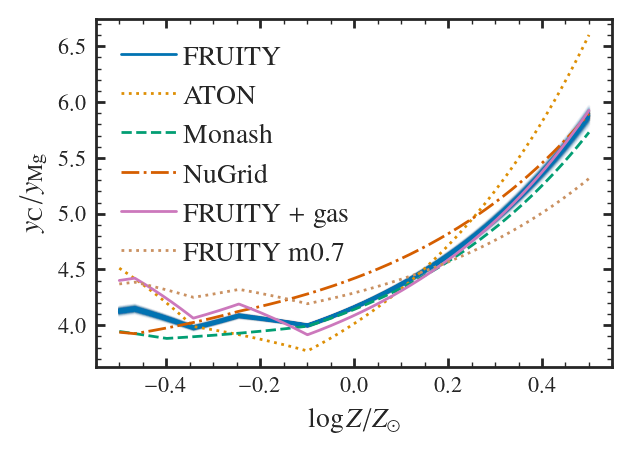

In [122]:

plt.figure()
plot_y_tot(results["fiducial"], y_agbs["fruity"], thin=100, alpha=0.01, color=arya.COLORS[0])

for i, (key, label) in enumerate(plot_labels.items()): 
    result = results[key]
    if key in y_agbs.keys():
        y_agb = y_agbs[key]
    else:
        print("warning, no agb for ", key)
        
        y_agb = y_agbs["fruity"]

    
    plot_y_tot_mean(result, y_agb, color=arya.COLORS[i], label=label, ls=["-", ":", "--", "-."][i%4])
    

# plot_ana(2.7e-3, 0.35e-3, color="black")
# plot_ana(3.1e-3, 0.35e-3, color="black")

plt.xlabel(r"$\log Z / Z_\odot$")
plt.ylabel(r"$y_{\rm C} / y_{\rm Mg}$")

plt.legend()
plt.savefig("figures/mcmc_y_tot.pdf")